In [2]:
import dosma as dm
import tensorflow as tf
print("tensorflow version: ", tf.__version__)
from dosma.core.med_volume import MedicalVolume
# Load some useful libraries
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sigpy as sp
from dosma import preferences
from dosma.scan_sequences import QDess, CubeQuant, Cones
from dosma.tissues import FemoralCartilage
from dosma.models import IWOAIOAIUnet2DNormalized
from sigpy.plot import ImagePlot
from dosma import ImageDataFormat
# Set the r-squared goodness of fit threshold to 0.
# All fitted pixels will be counted.
preferences.set("r2.threshold", 0.0, prefix="fitting")

tensorflow version:  2.8.0


In [3]:
import os
os.environ['PATH'] =  "elastix-5.0.1-linux/elastix-5.0.1-linux/bin"
os.environ['LD_LIBRARY_PATH'] = "elastix-5.0.1-linux/elastix-5.0.1-linux/lib"

/home/zimu/anaconda3/lib/python3.7/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mask * echo_2 / echo_1
/home/zimu/anaconda3/lib/python3.7/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask * echo_2 / echo_1
/home/zimu/anaconda3/lib/python3.7/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: overflow encountered in true_divide
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)
/home/zimu/anaconda3/lib/python3.7/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: divide by zero encountered in log
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)


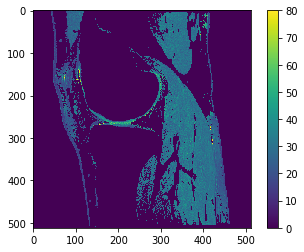

In [4]:
fc = FemoralCartilage()
qdess = QDess.from_dicom("knee_data/qdess", verbose=True)
t2map = qdess.generate_t2_map(fc, suppress_fat=True, suppress_fluid=True)
# Clip the estimated T2 values between [0, 80]
t2map.volumetric_map = np.clip(t2map.volumetric_map, 0, 80)
plt.imshow(t2map.volumetric_map.A[:, :, 34])
plt.colorbar()

In [5]:
dr = dm.DicomReader(num_workers=4, verbose=True)
volumes = dr.load("knee_data/qdess", group_by="EchoNumbers")
echo1, echo2 = tuple(volumes)
echo1, echo2 = echo1.astype(np.float), echo2.astype(np.float)
rss = np.sqrt(echo1 ** 2 + echo2 **2)
input_shape = rss.shape[:2] + (1,)
# trained using DESS data from the Osteoarthritis Initiative (OAI) iMorphics dataset
model = IWOAIOAIUnet2DNormalized(input_shape, "iwoai-2019-unet2d-normalized_fc-tc-pc-men_weights.h5")

/home/zimu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [6]:
outputs = model.generate_mask(qdess.calc_rss())

5/5 [==============================] - 54s 12s/step


In [7]:
fc.set_mask(outputs["fc"])

In [9]:
cq = CubeQuant.from_dicom("knee_data/cubequant", verbose=True, num_workers=4)

In [10]:
# Register cubequant scan to first echo of qDESS scan.
cq.interregister(qdess.volumes[0], target_mask_path=fc.get_mask())

[05/05 16:00:03 dm.scan_sequences.mri.cube_quant]: 
[05/05 16:00:03 dm.scan_sequences.mri.cube_quant]: ================================================================================
[05/05 16:00:03 dm.scan_sequences.mri.cube_quant]: Interregistering...
[05/05 16:00:03 dm.scan_sequences.mri.cube_quant]: Target: MedicalVolume(
  shape=(512, 512, 80),
  ornt=('SI', 'AP', 'LR')),
  spacing=(0.3125, 0.3125, 1.5),
  origin=(-61.6697, 50.8516, 88.5876),
  device=Device(type='cpu')
)
[05/05 16:00:03 dm.scan_sequences.mri.cube_quant]: Mask: MedicalVolume(
  shape=(512, 512, 80),
  ornt=('SI', 'AP', 'LR')),
  spacing=(0.3125, 0.3125, 1.5),
  origin=(-61.6697, 50.8516, 88.5876),
  device=Device(type='cpu')
)
[05/05 16:00:03 dm.scan_sequences.mri.cube_quant]: ================================================================================


100%|██████████| 1/1 [00:41<00:00, 41.07s/it]


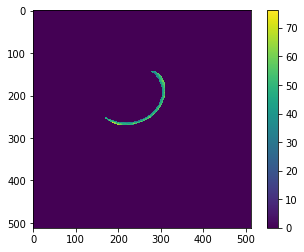

In [20]:
# Estimate T1-rho relaxation parameter for femoral cartilage region only.
# Limiting the region to femoral cartilage avoids spending time on fitting
# to pixels that are not required for downstream analysis.
# Load cubequant scan and perform intraregistration
t1rho = cq.generate_t1_rho_map(FemoralCartilage(), outputs["fc"].A)  #, fc.get_mask().A

# Clip values to a reasonable physiological range.
t1rho.volumetric_map = np.clip(t1rho.volumetric_map, 0, 100)

plt.imshow(t1rho.volumetric_map.A[:, :, 24])
plt.colorbar()